In [1]:
import sys
sys.path.append('../code/')

In [2]:
%load_ext autoreload
%autoreload 2

from libs import io
from libs import constants
from libs import vis
from libs import helpers
from postprocessing import factuality

# Setup

In [3]:
FACTUALITY_PATH = '../results/factuality'
PLOTS_PATH = '../results/plots'

In [4]:
vis.sns_reset()
vis.sns_paper_style()

## Data

In [5]:
df_authors = io.pd.concat([io.read_csv(io.path_join(FACTUALITY_PATH, f"{model}_author.csv"), index_col=0) for model in constants.LLMS], ignore_index=True)
df_authors['task_name'] = io.pd.Categorical(df_authors['task_name'], categories=constants.EXPERIMENT_TASKS, ordered=True)
df_authors.shape


(147622, 32)

# Factuality Author
Do they exist?

## Exists either in OA or APS

In [6]:
df_fact_authors_either = factuality.get_factuality_authors_either_OA_APS(df_authors)
df_fact_authors_either.head(2)

,model,task_name,mean,std
0,gemma2-9b,top_k,0.6,0.0
1,gemma2-9b,field,0.6,0.0


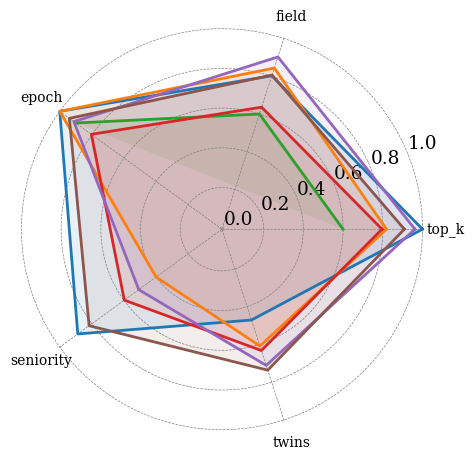

In [7]:
fname = 'factuality_author_mean_pct_real.pdf'
fn = io.path_join(PLOTS_PATH, fname)

hue = 'model'
x_col = 'task_name'
x_order = constants.EXPERIMENT_TASKS
mean_col = 'mean'
std_col = 'std'
hue_order = constants.LLMS
hue_colors = constants.LLMS_COLORS

vis.plot_spiderweb(df_fact_authors_either, x_col=x_col, x_order=x_order, y_col=mean_col,
                   hue=hue, hue_order=hue_order, hue_colors=hue_colors,
                   ylim=constants.PLOT_YLIM_SPIDER_PCT, 
                   legend=False, fn=fn,
                   figsize=constants.PLOT_FIGSIZE_SPIDER_NO_LEGEND)

In [8]:
df_fact_authors_either.groupby('model')['mean'].agg(['mean','std'])

,mean,std
model,,
gemma2-9b,0.700000,0.173205
llama-3.1-70b,0.841703,0.082265
llama-3.1-8b,0.734282,0.232991
llama3-70b,0.799138,0.188636
llama3-8b,0.832267,0.218366
mixtral-8x7b,0.693156,0.098320


/Users/espinl/Documents/CODE/LLM-project/LLMScholar-WWW24/Auditor/notebooks/../code/libs/helpers.py:34: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tmp = df.pivot_table(index=index_col, columns=columns_col, values=values_col).T.reset_index()
/Users/espinl/Documents/CODE/LLM-project/LLMScholar-WWW24/Auditor/notebooks/../code/libs/helpers.py:34: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tmp = df.pivot_table(index=index_col, columns=columns_col, values=values_col).T.reset_index()
/Users/espinl/Documents/CODE/LLM-project/LLMScholar-WWW24/Auditor/notebooks/../code/libs/vis.py:301: FutureWarning: The default of observed=False is deprecated and will be changed to T

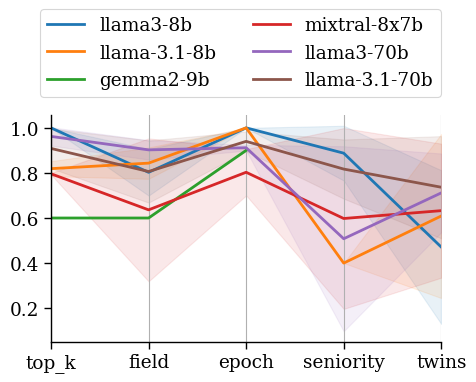

In [9]:
fn = io.path_join(PLOTS_PATH, fname.replace('.pdf','_parallel_coords.pdf'))

df_fact_field_mean_t = helpers.pivot_model_tasks(df_fact_authors_either, index_col=x_col, columns_col=hue, values_col=mean_col, x_order=x_order, hue_order=hue_order)
df_fact_field_std_t = helpers.pivot_model_tasks(df_fact_authors_either, index_col=x_col, columns_col=hue, values_col=std_col, x_order=x_order, hue_order=hue_order)
vis.plot_parallel_coords(df_fact_field_mean_t, hue=hue, hue_order=hue_order, hue_colors=hue_colors,
                         df_err=df_fact_field_std_t, 
                         legend_kwargs = constants.PLOT_LEGEND_KWARGS_PARALLEL_COORD,
                         figsize=constants.PLOT_FIGSIZE,
                         fn=fn)

## Only in one of them

In [10]:
df_fact_authors_both, df_fact_authors_oa, df_fact_authors_none = factuality.get_factuality_author_for_each_case(df_authors)
df_fact_authors_both.head(2)

,model,task_name,mean,std
0,gemma2-9b,top_k,0.6,0.0
1,gemma2-9b,field,0.6,0.0


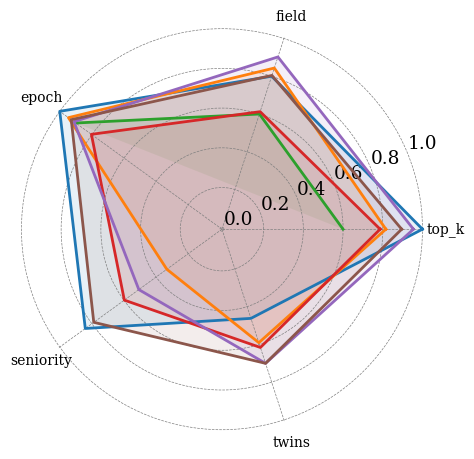

In [11]:
fn = None #io.path_join(PLOTS_PATH, 'factuality_author_mean_pct_both.pdf')
vis.plot_spiderweb(df_fact_authors_both, x_order=constants.EXPERIMENT_TASKS, x_col='task_name', y_col='mean',
                   hue='model', hue_order=constants.LLMS, hue_colors=constants.LLMS_COLORS,
                   ylim=constants.PLOT_YLIM_SPIDER_PCT,
                   legend=False,
                   figsize=constants.PLOT_FIGSIZE_SPIDER_NO_LEGEND)

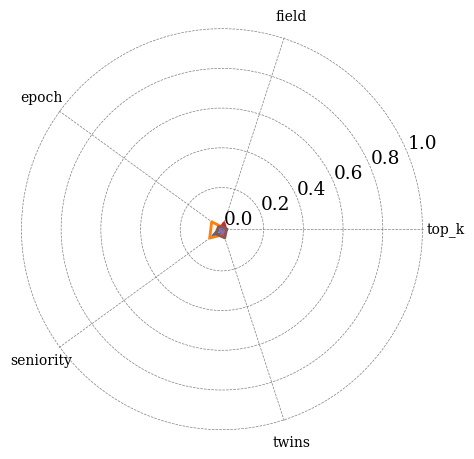

In [12]:

fn = None #io.path_join(PLOTS_PATH, 'factuality_author_mean_pct_both.pdf')
vis.plot_spiderweb(df_fact_authors_oa, x_order=constants.EXPERIMENT_TASKS, x_col='task_name', y_col='mean',
                   hue='model', hue_order=constants.LLMS, hue_colors=constants.LLMS_COLORS,
                   ylim=constants.PLOT_YLIM_SPIDER_PCT, legend=False,
                   figsize=constants.PLOT_FIGSIZE_SPIDER_NO_LEGEND)

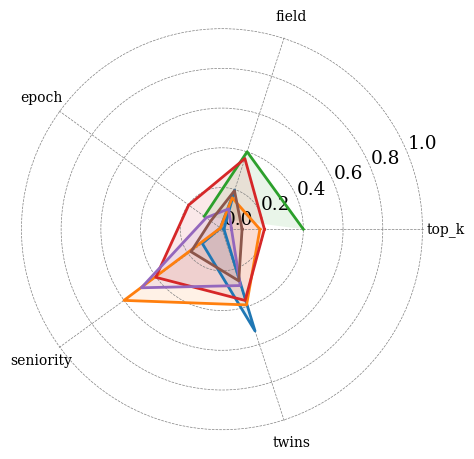

In [13]:

fn = None #io.path_join(PLOTS_PATH, 'factuality_author_mean_pct_both.pdf')
vis.plot_spiderweb(df_fact_authors_none, x_order=constants.EXPERIMENT_TASKS, x_col='task_name', y_col='mean',
                   hue='model', hue_order=constants.LLMS, hue_colors=constants.LLMS_COLORS,
                   ylim=constants.PLOT_YLIM_SPIDER_PCT,legend=False,
                   figsize=constants.PLOT_FIGSIZE_SPIDER_NO_LEGEND)

# Factuality Field

In [14]:
df_field = io.pd.concat([io.read_csv(io.path_join(FACTUALITY_PATH, f"{model}_{constants.EXPERIMENT_TASK_FIELD}.csv"), index_col=0) for model in constants.LLMS ], ignore_index=True)
df_field.shape

(16773, 20)

In [15]:
df_fact_field = factuality.get_factuality_field(df_field)
df_fact_field.head(2)

/Users/espinl/Documents/CODE/LLM-project/LLMScholar-WWW24/Auditor/notebooks/../code/postprocessing/factuality.py:61: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True  True  True ...  True False False]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_fact_field.loc[:,'fact_doi_author'] = df_fact_field['fact_doi_author'].notnull()


,model,factuality_field,mean,std
0,gemma2-9b,All,0.0,0.000000
24,llama3-8b,All,0.001075,0.010341


In [16]:
df_fact_field.groupby('model')['mean'].mean().sort_values()

model
gemma2-9b        0.266667
mixtral-8x7b     0.352063
llama-3.1-8b     0.442271
llama-3.1-70b    0.445056
llama3-70b       0.452807
llama3-8b         0.45849
Name: mean, dtype: object

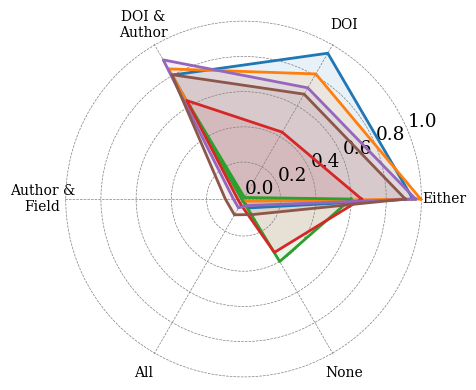

In [17]:
fname = 'factuality_field_mean_pct.pdf'
fn = io.path_join(PLOTS_PATH, fname)

hue = 'model'
x_col = 'factuality_field'
x_order = constants.FACTUALITY_FIELD_FACT_CHECKS
mean_col = 'mean'
std_col = 'std'
hue_order = constants.LLMS
hue_colors = constants.LLMS_COLORS

vis.plot_spiderweb(df_fact_field, x_col=x_col, x_order=x_order, y_col=mean_col,
                   hue=hue, hue_order=hue_order, hue_colors=hue_colors,
                   ylim=constants.PLOT_YLIM_SPIDER_PCT, 
                   legend=False, fn=fn,
                   figsize=constants.PLOT_FIGSIZE_SPIDER_NO_LEGEND)



/Users/espinl/Documents/CODE/LLM-project/LLMScholar-WWW24/Auditor/notebooks/../code/libs/vis.py:301: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group, tmp in df_err.groupby(hue):


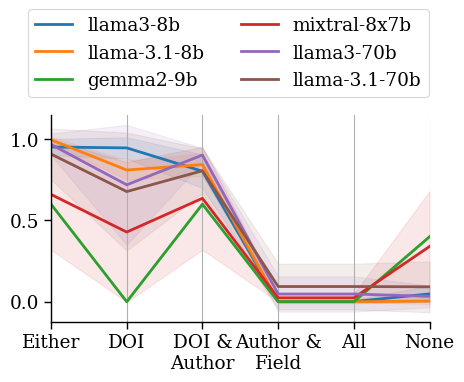

In [18]:
fn = io.path_join(PLOTS_PATH, fname.replace('.pdf','_parallel_coords.pdf'))

df_fact_field_mean_t = helpers.pivot_model_tasks(df_fact_field, index_col=x_col, columns_col=hue, values_col=mean_col, x_order=x_order, hue_order=hue_order)
df_fact_field_std_t = helpers.pivot_model_tasks(df_fact_field, index_col=x_col, columns_col=hue, values_col=std_col, x_order=x_order, hue_order=hue_order)
vis.plot_parallel_coords(df_fact_field_mean_t, hue=hue, hue_order=hue_order, hue_colors=hue_colors,
                         df_err=df_fact_field_std_t, 
                         legend_kwargs = constants.PLOT_LEGEND_KWARGS_PARALLEL_COORD,
                         figsize=constants.PLOT_FIGSIZE,
                         fn=fn)

# Seniority

In [19]:
df_seniority = io.pd.concat([io.read_csv(io.path_join(FACTUALITY_PATH, f"{model}_{constants.EXPERIMENT_TASK_SENIORITY}.csv"), index_col=0) for model in constants.LLMS ], ignore_index=True)
df_seniority.shape

/var/folders/lj/_xkc5wfx66n7wxk15hc05rjm0000gn/T/ipykernel_61299/4055560821.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_seniority = io.pd.concat([io.read_csv(io.path_join(FACTUALITY_PATH, f"{model}_{constants.EXPERIMENT_TASK_SENIORITY}.csv"), index_col=0) for model in constants.LLMS ], ignore_index=True)


(12072, 24)

In [20]:
df_fact_seniority = factuality.get_factuality_seniority(df_seniority)
df_fact_seniority.head(2)

,model,factuality_field,mean,std
16,llama3-8b,Matched\n(active),0.725447,0.081554
1,llama-3.1-70b,Matched\n(active),0.403653,0.140587


In [21]:
df_fact_seniority.groupby('model')['mean'].mean().sort_values()

model
llama-3.1-8b          0.2
llama-3.1-70b    0.260439
llama3-8b        0.365436
llama3-70b       0.401181
mixtral-8x7b     0.418919
Name: mean, dtype: object

gemma2-9b (0, 4) single positional indexer is out-of-bounds


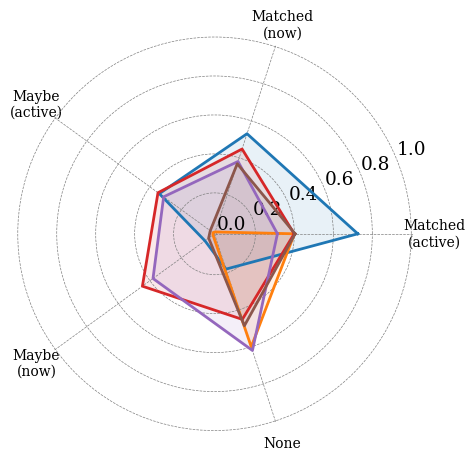

In [22]:
fname = 'factuality_seniority_mean_pct.pdf'
fn = io.path_join(PLOTS_PATH, fname)

hue = 'model'
x_col = 'factuality_field'
x_order = constants.FACTUALITY_SENIORITY_FACT_CHECKS
mean_col = 'mean'
std_col = 'std'
hue_order = constants.LLMS
hue_colors = constants.LLMS_COLORS


vis.plot_spiderweb(df_fact_seniority, x_col=x_col, x_order=x_order, y_col=mean_col,
                   hue=hue, hue_order=hue_order, hue_colors=hue_colors,
                   ylim=constants.PLOT_YLIM_SPIDER_PCT, 
                   legend=False, fn=fn,
                   figsize=constants.PLOT_FIGSIZE_SPIDER_NO_LEGEND)


/Users/espinl/Documents/CODE/LLM-project/LLMScholar-WWW24/Auditor/notebooks/../code/libs/vis.py:301: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group, tmp in df_err.groupby(hue):


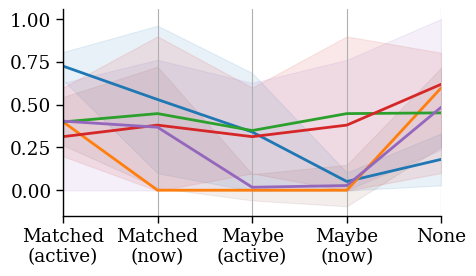

In [23]:
fn = io.path_join(PLOTS_PATH, fname.replace('.pdf','_parallel_coords.pdf'))

df_fact_seniority_mean_t = helpers.pivot_model_tasks(df_fact_seniority, index_col=x_col, columns_col=hue, values_col=mean_col, x_order=x_order, hue_order=hue_order)
df_fact_seniority_std_t = helpers.pivot_model_tasks(df_fact_seniority, index_col=x_col, columns_col=hue, values_col=std_col, x_order=x_order, hue_order=hue_order)
vis.plot_parallel_coords(df_fact_seniority_mean_t, hue=hue, hue_order=hue_order, hue_colors=hue_colors,
                         df_err=df_fact_seniority_std_t, 
                         legend=False,
                         figsize=constants.PLOT_FIGSIZE_NO_LEGEND,
                         fn=fn)

# Epoch

In [24]:
df_epoch = io.pd.concat([io.read_csv(io.path_join(FACTUALITY_PATH, f"{model}_{constants.EXPERIMENT_TASK_EPOCH}.csv"), index_col=0) for model in constants.LLMS ], ignore_index=True)
df_epoch.shape

(14165, 21)

In [25]:
df_fact_epoch = factuality.get_factuality_epoch(df_epoch)
df_fact_epoch.head(2)

/Users/espinl/Documents/CODE/LLM-project/LLMScholar-WWW24/Auditor/notebooks/../code/postprocessing/factuality.py:151: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 1 0 ... 1 0 1]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_fact_epoch.loc[:,'fact_epoch_requested'] = df_fact_epoch.fact_epoch_requested.astype(int)
/Users/espinl/Documents/CODE/LLM-project/LLMScholar-WWW24/Auditor/notebooks/../code/postprocessing/factuality.py:152: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 1 0 ... 1 0 1]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_fact_epoch.loc[:,'fact_epoch_llm_in_gt'] = df_fact_epoch.fact_epoch_llm_in_gt.astype(int)
/Users/espinl/Documents/CODE/LLM-project/LLMScholar-WWW24/Auditor/notebooks/../code/postprocessing/factuality.py:153: FutureWarn

,model,factuality_field,mean,std
23,llama3-8b,Matched,0.272727,0.0
3,gemma2-9b,Matched,0.700000,0.0


In [26]:
df_fact_epoch.groupby('model')['mean'].mean().sort_values()

model
llama3-8b        0.345455
mixtral-8x7b     0.380108
llama-3.1-8b     0.411111
llama3-70b       0.432597
llama-3.1-70b    0.434425
gemma2-9b        0.440000
Name: mean, dtype: float64

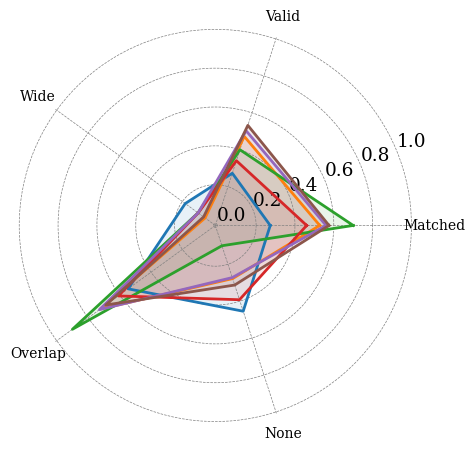

In [27]:
fname = 'factuality_epoch_mean_pct.pdf'
fn = io.path_join(PLOTS_PATH, fname)

hue = 'model'
x_col = 'factuality_field'
x_order = constants.FACTUALITY_EPOCH_FACT_CHECKS
mean_col = 'mean'
std_col = 'std'
hue_order = constants.LLMS
hue_colors = constants.LLMS_COLORS

vis.plot_spiderweb(df_fact_epoch, x_col=x_col, x_order=x_order, y_col=mean_col,
                   hue=hue, hue_order=hue_order, hue_colors=hue_colors,
                   ylim=constants.PLOT_YLIM_SPIDER_PCT, 
                   legend=False, fn=fn,
                   figsize=constants.PLOT_FIGSIZE_SPIDER_NO_LEGEND)


/Users/espinl/Documents/CODE/LLM-project/LLMScholar-WWW24/Auditor/notebooks/../code/libs/vis.py:301: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group, tmp in df_err.groupby(hue):


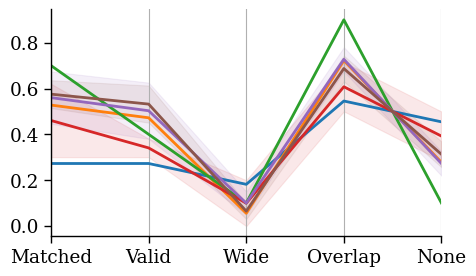

In [28]:
fn = io.path_join(PLOTS_PATH, fname.replace('.pdf','_parallel_coords.pdf'))

df_fact_epoch_mean_t = helpers.pivot_model_tasks(df_fact_epoch, index_col=x_col, columns_col=hue, values_col=mean_col, x_order=x_order, hue_order=hue_order)
df_fact_epoch_std_t = helpers.pivot_model_tasks(df_fact_epoch, index_col=x_col, columns_col=hue, values_col=std_col, x_order=x_order, hue_order=hue_order)
vis.plot_parallel_coords(df_fact_epoch_mean_t, hue=hue, hue_order=hue_order, hue_colors=hue_colors,
                         df_err=df_fact_epoch_std_t, 
                         legend=False,
                         figsize=constants.PLOT_FIGSIZE_NO_LEGEND,
                         fn=fn)